In [69]:
# if packages are missing, please uncomment the lines below and run cell
# %pip install -r ./requirements.txt

# 1.26.4 is needed for something else 
# The following depend on your gpu and ur cuda-enabledness. 
# %pip install torch==2.3.0+cpu
# %pip install torchvision==0.18.0+cpu
# %pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.3/index.html

In [70]:
# python standard library
import itertools
import json
import os
import threading
from abc import ABC, abstractmethod
from collections.abc import Callable, Sequence
from enum import Enum, auto

# yes i like static typing why do you ask?
from typing import Any, Union

# not python standard library
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim
from baseline_model import get_flowers_dataloaders, set_seed, train_epoch, validate
from connection_test import hugging_face_connectivity_test
from mmcv.ops import DeformConv2d
from safetensors.torch import load_file as safe_load
from tqdm.notebook import tqdm


In [71]:
# === Model Setup ===
resnet_histories = {}

# Default list for full experiments
model_names_default = [
	"resnet18",
	"resnet34",
	"resnet50",
	"resnet101",
	"resnet152", # doesn't fit in my machine's gpu
	"vit_base_patch32_224",
	"vit_base_patch16_224", # doesn't fit in my machine's gpu
]

# Smaller list for quick debugging
model_names_debug = [
	"resnet18",
	"resnet34",
	"vit_base_patch32_224",
]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed()
train_loader, val_loader, test_loader = get_flowers_dataloaders(batch_size=32)
tiny_batch_train_loader, tiny_batch_val_loader, tiny_batch_test_loader = get_flowers_dataloaders(batch_size=16)
print(device)

Seed set to 42


cuda


# Utils: Model creation, model evaluation

In [73]:
def freeze_head(model, model_name):
	if "vit" in model_name:
		for name, param in model.named_parameters():
			if not name.startswith("head"):  # ViT classifier head
				param.requires_grad = False
	elif "resnet" in model_name:
		for name, param in model.named_parameters():
			if "fc" not in name:  # 'fc' is the final classifier for resnets
				param.requires_grad = False
	else:
		raise NotImplementedError(
			f"Freeze head received unknown model type {model_name}"
		)
	return model


def create_model_with_timeout(model_name, num_classes, device, timeout=10):
	"""
	Create a timm model safely with timeout and fallback logic.
	Tries local weights first, then checks Hugging Face and retries online if accessible.
	"""
	model_container = {}

	def target():
		try:
			model = timm.create_model(
				model_name, pretrained=False, num_classes=num_classes
			)

			# --- Locate local weights ---
			weights_dir = os.path.join("..", "original_weights")
			safe_path = os.path.join(weights_dir, f"{model_name}.safetensors")
			pth_path = os.path.join(weights_dir, f"{model_name}.pth")

			if os.path.exists(safe_path):
				weight_path = safe_path
			elif os.path.exists(pth_path):
				weight_path = pth_path
			else:
				raise FileNotFoundError(
					f"No local weight file found for '{model_name}' in '{weights_dir}'"
				)

			# --- Load local weights safely ---
			try:
				if weight_path.endswith(".safetensors"):
					state_dict = safe_load(weight_path)
				else:
					# PyTorch .pth / .pt file
					state_dict = torch.load(
						weight_path, map_location="cpu", weights_only=False
					)
			except Exception as e:
				raise RuntimeError(
					f"Error loading local weight file '{weight_path}': {e}"
				) from e

			# --- Apply weights ---
			try:
				checkpoint = state_dict.copy()
				for key in list(checkpoint.keys()):
					if key.startswith("fc.") or key.startswith("head."):
						del checkpoint[key]

				# Now load safely
				missing, unexpected = model.load_state_dict(checkpoint, strict=False)
				print(
					f"Ignored missing keys: {missing}"
				)  # should include 'fc.weight', 'fc.bias'
				print(f"Ignored unexpected keys: {unexpected}")
			except Exception as e:
				raise RuntimeError(f"Weight mismatch for '{model_name}': {e}")

			# --- Move to device ---
			model_container["model"] = model.to(device)

		except Exception as e:
			model_container["error"] = str(e)

	# --- Run model creation in separate thread with timeout ---
	thread = threading.Thread(target=target)
	thread.start()
	thread.join(timeout)

	if thread.is_alive():
		raise TimeoutError(f"Creating model '{model_name}' timed out after {timeout}s.")

	# --- Handle failure: fallback path ---
	if "error" in model_container:
		print(f"Local load failed: {model_container['error']}")

		try:
			print("\n")
			hf_status = hugging_face_connectivity_test()
		except Exception as e:
			raise RuntimeError(f"Hugging Face connectivity test failed to run: {e}") from e

		# interpret test output if no connection
		if not hf_status:
			raise RuntimeError(
				"Local Weights not found and could not reach Hugging Face. Check your DNS, VPN, or network access."
			)

		# --- Retry with online download ---
		print("Retrying model creation via TIMM (pretrained=True)...")
		try:
			model = timm.create_model(
				model_name, pretrained=True, num_classes=num_classes
			)
			model_container["model"] = model.to(device)
			print(
				f"✅ Successfully downloaded and loaded '{model_name}' from Hugging Face."
			)
		except Exception as e:
			raise RuntimeError(
				f"Retried online download but still failed for '{model_name}': {e}"
			) from e

	model_container["model"] = freeze_head(model_container["model"], model_name)
	return model_container["model"]

In [74]:
class EarlyStopper:
	def __init__(self, patience=10, min_delta=0):
		self.patience = patience
		self.min_delta = min_delta
		self.counter = 0
		self.min_validation_loss = np.inf

	def __call__(self, validation_loss):
		if validation_loss < self.min_validation_loss:
			self.min_validation_loss = validation_loss
			self.counter = 0
		elif validation_loss > (self.min_validation_loss + self.min_delta):
			self.counter += 1
			if self.counter >= self.patience:
				return True
		return False

In [75]:
class ModelTransform(ABC):
	def __init__(self, name: str):
		self.name = name
		self.__name__ = name

	@abstractmethod
	def __call__(self, model: nn.Module) -> nn.Module:
		raise NotImplementedError

	def applies_to(self, model_name: str) -> bool:
		"""Return True if this transform actually modifies the model. Default to accepting vit and resnet"""
		if "resnet" in model_name:
			return True
		elif "vit" in model_name:
			return True
		else:
			raise NotImplementedError(f"{model_name} not implemented!")
	
	# I'll have to do a python nono later on since i want the save states to be all lower case, so transform classes are lowercase
	def __repr__(self):
		return self.name


In [ ]:
def get_performance(
	model_name: str,
	num_classes: int = 102,
	num_epochs: int = 30,
	batch_size: int = 32,
	lr: float = 0.001,
	weight_decay: float = 1e-4,
	scheduler_step_size: int = 10,
	scheduler_gamma: float = 0.1,
	device: str = "cuda" if torch.cuda.is_available() else "cpu",
	model_transform: Callable[[nn.Module], nn.Module] | None = None,
):
	"""
	Train and evaluate any timm model (ViT, ResNet, etc.).
	Note: model_transform must unfreeze layers by itself. By default, all old pretrained layers are frozen
	"""
	# === 1. Setup ===
	history = {
		"train_loss": [],
		"train_acc": [],
		"val_loss": [],
		"val_acc": [],
		"test_loss": float,
		"test_acc": float,
	}
	best_val_acc = 0.0
	best_model_state = None
	early_stop = EarlyStopper()

	# === 2. Create model ===
	model = create_model_with_timeout(
		model_name, num_classes=num_classes, device=device
	)
	if model_transform is not None:
		model = model_transform(model)

	criterion = nn.CrossEntropyLoss().to(device)
	optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
	scheduler = optim.lr_scheduler.StepLR(
		optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
	)

	if model_name == "resnet152" or model_name == "vit_base_patch16_224":
		train_loader_used = tiny_batch_train_loader
		val_loader_used = tiny_batch_val_loader
		test_loader_used = tiny_batch_test_loader
	else:
		train_loader_used = train_loader
		val_loader_used = val_loader
		test_loader_used = test_loader

	assert num_epochs > 0, "Num epochs must be greater than 0!"

	# === 3. Training Loop ===
	for epoch in tqdm(
		range(num_epochs), desc=f"Training Epochs ({model_name})", unit="epoch"
	):
		current_lr = scheduler.get_last_lr()[0]

		train_loss, train_acc = train_epoch(
			model, train_loader_used, criterion, optimizer, device
		)
		val_loss, val_acc = validate(model, val_loader_used, criterion, device)
		scheduler.step()

		# Record metrics
		for key, val in zip(
			["train_loss", "train_acc", "val_loss", "val_acc"],
			[train_loss, train_acc, val_loss, val_acc], strict=True,
		):
			history[key].append(val)

		# Save best model
		if val_acc > best_val_acc:
			best_val_acc = val_acc
			best_model_state = model.state_dict().copy()

		if early_stop(val_loss):
			tqdm.write("Early stopping triggered.")
			break

		tqdm.write(
			f"Epoch [{epoch + 1}/{num_epochs}] "
			f"LR: {current_lr:.6f} | "
			f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
			f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
		)

	# === 4. Test Evaluation ===
	test_loss, test_acc = validate(
		model, test_loader_used, criterion, device, valid_or_test="test"
	)
	history["test_loss"] = test_loss
	history["test_acc"] = test_acc

	assert best_val_acc > 0.0 and best_model_state is not None, (
		"The model validation accuracy is 0! Check your data or training loop."
	)

	model.load_state_dict(best_model_state)
	print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
	print(f"\nTest Accuracy: {test_acc:.2f}%")

	num_params = sum(p.numel() for p in model.parameters())
	history["num_params"] = num_params
	return model, history, num_params

In [77]:
class Mode(Enum):
	DEBUG_OVERWRITE = auto()  # short epochs, overwrite results
	FULL_OVERWRITE = auto()  # long epochs, overwrite results
	FULL_SKIP = auto()  # long epochs, skip existing results
	DEBUG_SKIP = auto()  # short epochs, skip existing results
	LOAD_ONLY = auto() # skip all training, load existing only


# TODO: Remember to run Mode.FULL_OVERWRITE then change default to LOAD_ONLY before handing in!
def get_or_compute_model_results(
	mode: Mode = Mode.DEBUG_SKIP,
	model_names: list[str] | None = None,
	model_transforms: Sequence[ModelTransform | None] = (),
	preserve_base_case: bool = True
) -> dict[str, dict[str, Any]]:
	"""
	Compute or load model results, supporting transformations and different modes.

	Args:
		mode (Mode):
			Specifies run behavior:
				- Mode.DEBUG_OVERWRITE: short epochs, overwrite results.
				- Mode.FULL_OVERWRITE: long epochs, overwrite results.
				- Mode.FULL_SKIP: long epochs, skip existing results.
				- Mode.DEBUG_SKIP: short epochs, skip existing results.

		model_names (Optional[list[str]]):
			List of model names to evaluate. If None, defaults are chosen
			based on the mode (debug vs full).

		model_transforms (Sequence[Optional[Callable[[nn.Module], nn.Module]]]):
			Functions applied to modify the model (e.g., pruning, deformable conv).
			Each transform must take an `nn.Module` and return an `nn.Module`.
			The untransformed model (None) is always included automatically.

		preserve_base_case (bool):
			if True, will not overwrite the base case without transforms, regardless of mode. 
			if False, base case without transforms will be treated the same as transformed cases

	Returns:
		dict[str, dict[str, Any]]:
			A mapping from `model_name` (including transform suffix) to its training
			history dictionary, including performance metrics and parameter count.
	"""

	# Ensure all transforms are distinct by name
	transform_names = [t.__name__ for t in model_transforms if t is not None]
	assert len(transform_names) == len(set(transform_names)), (
		"Duplicate model transform names detected. "
		f"Each transform must have a unique function name.\nTransform names:\n{transform_names}"
	)

	histories: dict[str, dict[str, Any]] = {}

	# Select default model names if not provided
	if model_names is None:
		if mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]:
			model_names = model_names_debug
		else:
			model_names = model_names_default
	else:
		# User explicitly provided models; assume full results are desired
		if mode not in (Mode.FULL_OVERWRITE, Mode.FULL_SKIP):
			mode = Mode.FULL_SKIP

	for model_name in model_names:
		for model_transform in itertools.chain(model_transforms, (None,)):

			# if there is a transform (not just testing the model by itself without a transform) and the transform doesnt apply to this model, skip
			if model_transform is not None and not(model_transform.applies_to(model_name)):
				continue

			transformed_model_name = (
				f"{model_name}_{model_transform.__name__}"
				if model_transform is not None
				else model_name
			)

			weights_dir = os.path.join("results", "model_weights", transformed_model_name)
			os.makedirs(weights_dir, exist_ok=True)
			weights_path = os.path.join(weights_dir, f"{transformed_model_name}_best.pth")
			metrics_path = f"results/metrics_{transformed_model_name}.json"

			# Skip computation if results already exist
			# If mode is overwrite, dont skip computation unless preserve base case and processing base case
			if (
				os.path.exists(weights_path)
				and os.path.exists(metrics_path)
				and (mode not in [Mode.DEBUG_OVERWRITE, Mode.FULL_OVERWRITE] or (preserve_base_case and model_transform is None))
			):
				print(f"Found existing results for '{transformed_model_name}', loading metrics...")
				with open(metrics_path) as f:
					history = json.load(f)
				histories[transformed_model_name] = history
				continue
			
			elif mode == Mode.LOAD_ONLY:
				print(f"Performance for '{transformed_model_name}'not found. Skipping...")
				continue

			print(f"Computing performance for '{transformed_model_name}'...")
			short_run = mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]

			# Compute model performance
			model, history, num_params = get_performance(
				model_name,
				num_epochs=2 if short_run else 30,
				model_transform=model_transform,
			)

			# Save model weights
			torch.save(model.state_dict(), weights_path)
			print(f"Model weights saved to {weights_path}")

			# Save metrics
			with open(metrics_path, "w") as f:
				json.dump(history, f, indent=4)
			print(f"Metrics saved to {metrics_path}")

			histories[transformed_model_name] = history

	# Save combined histories
	combined_path = "results/all_histories.json"
	with open(combined_path, "w") as f:
		json.dump(histories, f, indent=4)
	print(f"All histories saved to {combined_path}")

	return histories

In [78]:
def plot_model_histories(histories: dict, save_dir: str = "results/plots", plot_save_name: str = ""):
	"""
	Plot validation accuracy per epoch and final test accuracy vs number of parameters.
	Also saves the plots as PNG files in `save_dir`.

	Args:
		histories: dict mapping transformed_model_name -> history dict.
		save_dir: directory path where plots are saved (default: "results/plots")
	"""
	os.makedirs(save_dir, exist_ok=True)

	# --- 1. Validation accuracy vs epoch ---
	plt.figure(figsize=(10, 6))
	for i, (transformed_model_name, h) in enumerate(histories.items(), start=1):
		val_acc_list = h.get("val_acc") or h.get("best_val_acc_list") or []
		if not val_acc_list:
			print(f"No validation accuracy found for {transformed_model_name}")
			continue

		label = f"{i}. {transformed_model_name}"
		plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label=label)
		plt.text(len(val_acc_list), val_acc_list[-1], str(i), fontsize=8, va="center", ha="left")

	plt.xlabel("Epoch")
	plt.ylabel("Validation Accuracy (%)")
	plt.title("Validation Accuracy vs Epoch")
	plt.legend(
		title="Model / Transform",
		fontsize=8,
		loc="upper left",
		bbox_to_anchor=(1.05, 1),
	)
	plt.grid(True)
	plt.tight_layout()

	# ilename creation
	val_filename = f"{plot_save_name}_validation_accuracy_vs_epoch.png" if plot_save_name else "validation_accuracy_vs_epoch.png"
	val_plot_path = os.path.join(save_dir, val_filename)

	plt.savefig(val_plot_path, bbox_inches="tight", dpi=300)
	print(f"Saved: {val_plot_path}")
	plt.show()

	# --- 2. Final test accuracy vs total parameters ---
	groups = {"resnet": [], "vit": [], "other": []}
	markers = {"resnet": "o", "vit": "s", "other": "^"}
	colors_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

	plt.figure(figsize=(10, 6))
	idx = 1

	for group in groups:
		group_colors = itertools.cycle(colors_list)
		for transformed_model_name, h in histories.items():
			test_acc = h.get("test_acc")
			num_params = h.get("num_params")
			if test_acc is None or num_params is None:
				continue

			name_lower = transformed_model_name.lower()
			model_group = (
				"vit" if "vit" in name_lower else "resnet" if "resnet" in name_lower else "other"
			)
			if model_group != group:
				continue

			color = next(group_colors)
			marker = markers[group]
			label = f"{idx}. {transformed_model_name}"
			plt.scatter(num_params, test_acc, label=label, color=color, marker=marker, s=80)
			plt.text(num_params, test_acc, str(idx), fontsize=8, va="bottom", ha="center")
			idx += 1

	plt.xscale("log")
	plt.xlabel("Total Parameters (log scale)")
	plt.ylabel("Test Accuracy (%)")
	plt.title("Test Accuracy vs Model Size")
	plt.legend(
		title="Model / Transform",
		fontsize=8,
		loc="upper left",
		bbox_to_anchor=(1.05, 1),
	)
	plt.grid(True, which="both", ls="--", alpha=0.5)
	plt.tight_layout()

	# filename creation 
	test_filename = f"{plot_save_name}_test_accuracy_vs_model_size.png" if plot_save_name else "test_accuracy_vs_model_size.png"
	test_plot_path = os.path.join(save_dir, test_filename)

	plt.savefig(test_plot_path, bbox_inches="tight", dpi=300)
	print(f"Saved: {test_plot_path}")
	plt.show()


# Different Depths: Different ResNets + Comparison with ViTs

### Model Sources and Experiment Setup

If you need to **download the models manually**, here are the sources:

- [ResNet18](https://huggingface.co/timm/resnet18.tv_in1k/tree/main)  
- [ResNet34](https://huggingface.co/timm/resnet34.tv_in1k/tree/main)  
- [ResNet50](https://huggingface.co/timm/resnet50.tv_in1k/tree/main)  
- [ResNet101](https://huggingface.co/timm/resnet101.tv_in1k/tree/main)  
- [ResNet152](https://huggingface.co/timm/resnet152.tv_in1k/tree/main)  
- [ViT Base Patch32 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch32_224.orig_in21k/tree/main)  
- [ViT Base Patch16 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch16_224.orig_in21k/tree/main)

---

#### Notes
- **ResNet memory** scales *linearly* with the number of layers — this is because intermediate activations must be stored for backpropagation.  
	> My 7.6 GB GPU should handle all ResNet variants; your GPU may differ
- **ViT memory** scales *quadratically* (roughly inversely with patch size).  
	> My GPU likely cannot handle `vit_large` or `vit_huge`.
- **Training datasets differ:**
	- ResNets use **ImageNet-1k**
	- ViTs use **ImageNet-21k**
- Chosen ViT models are ones without heavy modern augmentations, for a fairer comparison.

---


Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50', loading metrics...
Found existing results for 'resnet101', loading metrics...
Found existing results for 'resnet152', loading metrics...
Found existing results for 'vit_base_patch32_224', loading metrics...
Found existing results for 'vit_base_patch16_224', loading metrics...
All histories saved to results/all_histories.json
Saved: basic\validation_accuracy_vs_epoch.png


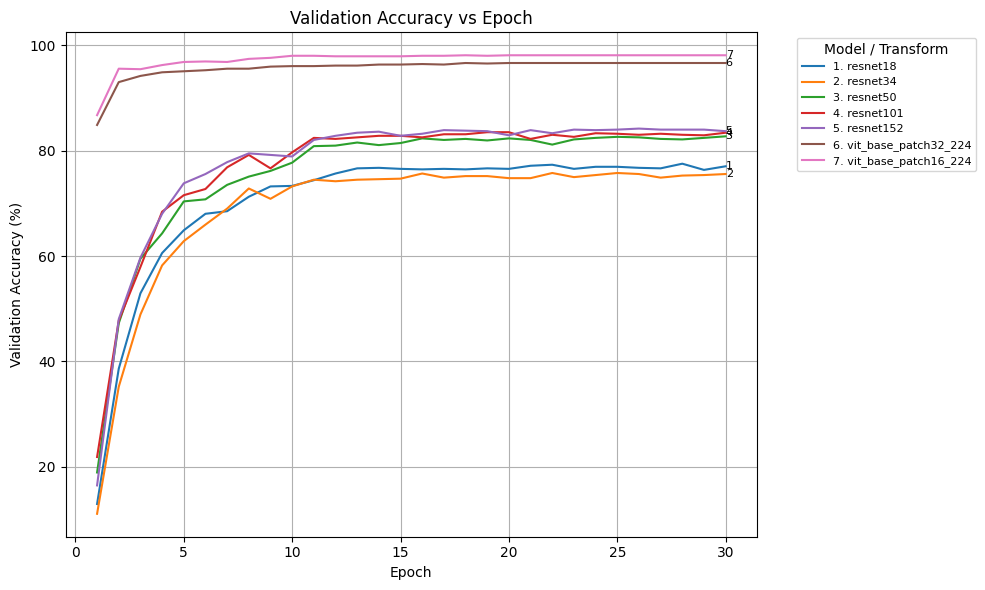

Saved: basic\test_accuracy_vs_model_size.png


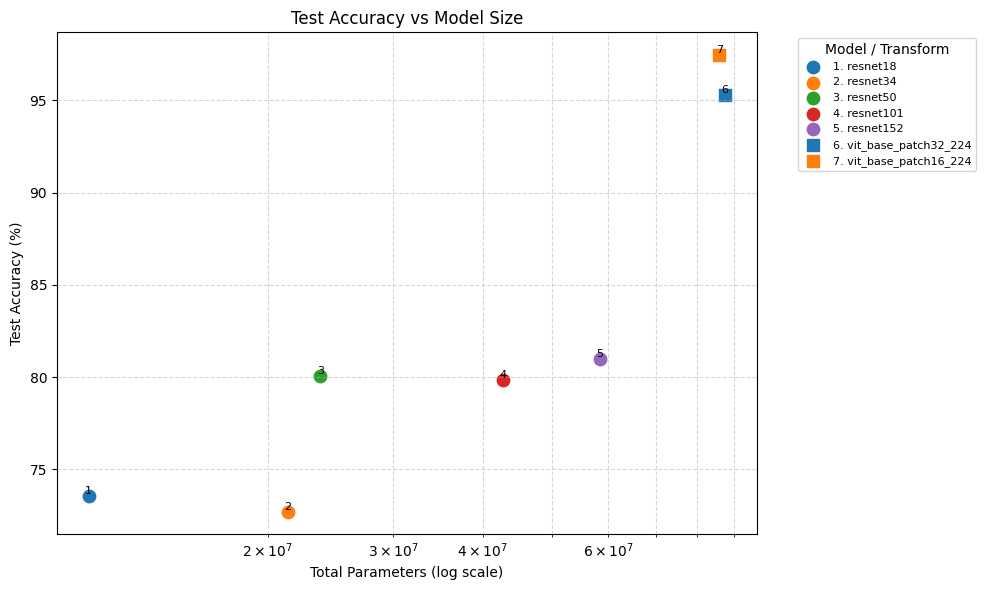

In [79]:
histories = get_or_compute_model_results(Mode.FULL_SKIP)
plot_model_histories(histories, "basic")

# Reduce Parameters: Pruning

In [80]:
def pruning(
	model: nn.Module,
	structured: bool = False,
	global_prune: bool = True,
	amount: float = 0.3,
) -> nn.Module:
	"""
	Apply structured or unstructured pruning to a pretrained model.

	This function is designed to be called *before training* (e.g. in `get_performance`),
	on models loaded with pretrained weights.

	Args:
		model: 
			A model instance from timm, either ResNet or VisionTransformer.
		structured: 
			If True, perform structured pruning (removing entire channels).
		global_prune: 
			If True, prune globally across all layers instead of layer-wise.
		amount: 
			Fraction of parameters to prune (e.g., 0.3 means prune 30%).

	Returns:
		model: The pruned model ready for fine-tuning or evaluation.

	Notes:
		- For ResNets, only convolutional layers (`nn.Conv2d`) are pruned.
		- For ViTs, only MLP layers (`mlp.fc1`, `mlp.fc2`) are pruned to preserve attention structure.
		- Structured pruning is applied using L2 norm across output channels.
	"""
	assert not (structured and global_prune), "Global structured pruning could theoretically remove all layers from a filter."

	modules_to_prune: list[nn.Module] = []

	for module_name, module in model.named_modules():
		if isinstance(model, timm.models.resnet.ResNet) and isinstance(module, nn.Conv2d):
			modules_to_prune.append(module)
			# fine tune after pruning
			module.requires_grad_(True)
		elif isinstance(model, timm.models.vision_transformer.VisionTransformer) and "mlp.fc" in module_name:
			modules_to_prune.append(module)
			# fine tune after pruning
			module.requires_grad_(True)

	# === Global pruning ===
	if global_prune and not structured:
		prune.global_unstructured(
			parameters=[(m, "weight") for m in modules_to_prune],
			pruning_method=prune.L1Unstructured,
			amount=amount,
		)
		for module in modules_to_prune:
			prune.remove(module, "weight")

	# === Layer-wise pruning ===
	elif not global_prune and not structured:
		for module in modules_to_prune:
			prune.l1_unstructured(module, name="weight", amount=amount)
			prune.remove(module, "weight")

	# === Structured pruning ===
	elif structured:
		for module in modules_to_prune:
			prune.ln_structured(
				module=module,
				name="weight",
				amount=amount,
				n=2,  # L2 norm
				dim=0,  # Prune output channels
			)
			prune.remove(module, "weight")

	return model

# === Pruning transform ===
class PruneTransform(ModelTransform):
	def __init__(self, name: str, structured: bool, global_prune: bool, amount: float = 0.3):
		super().__init__(name)
		self.structured = structured
		self.global_prune = global_prune
		self.amount = amount

	def __call__(self, model: nn.Module) -> nn.Module:
		assert not (self.structured and self.global_prune), \
			"Global structured pruning could theoretically remove all filters."

		modules_to_prune: list[nn.Module] = []

		for module_name, module in model.named_modules():
			if isinstance(model, timm.models.resnet.ResNet) and isinstance(module, nn.Conv2d):
				modules_to_prune.append(module)
				module.requires_grad_(True)
			elif isinstance(model, timm.models.vision_transformer.VisionTransformer) and "mlp.fc" in module_name:
				modules_to_prune.append(module)
				module.requires_grad_(True)

		if self.global_prune and not self.structured:
			prune.global_unstructured(
				parameters=[(m, "weight") for m in modules_to_prune],
				pruning_method=prune.L1Unstructured,
				amount=self.amount,
			)
			for module in modules_to_prune:
				prune.remove(module, "weight")

		elif not self.global_prune and not self.structured:
			for module in modules_to_prune:
				prune.l1_unstructured(module, name="weight", amount=self.amount)
				prune.remove(module, "weight")

		elif self.structured:
			for module in modules_to_prune:
				prune.ln_structured(
					module=module,
					name="weight",
					amount=self.amount,
					n=2,
					dim=0,
				)
				prune.remove(module, "weight")

		return model


# === Instantiate variants ===
structured_local_pruning = PruneTransform(
	name="structured_local_pruning", structured=True, global_prune=False, amount=0.3
)

unstructured_global_pruning = PruneTransform(
	name="unstructured_global_pruning", structured=False, global_prune=True, amount=0.3
)

unstructured_local_pruning = PruneTransform(
	name="unstructured_local_pruning", structured=False, global_prune=False, amount=0.3
)

Found existing results for 'resnet18_structured_local_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34_structured_local_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50_structured_local_pruning', loading metrics...
Found existing results for 'resnet50_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet50_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet50', loading metrics...
Found existing results for 'resnet101_structured_local_pruning',

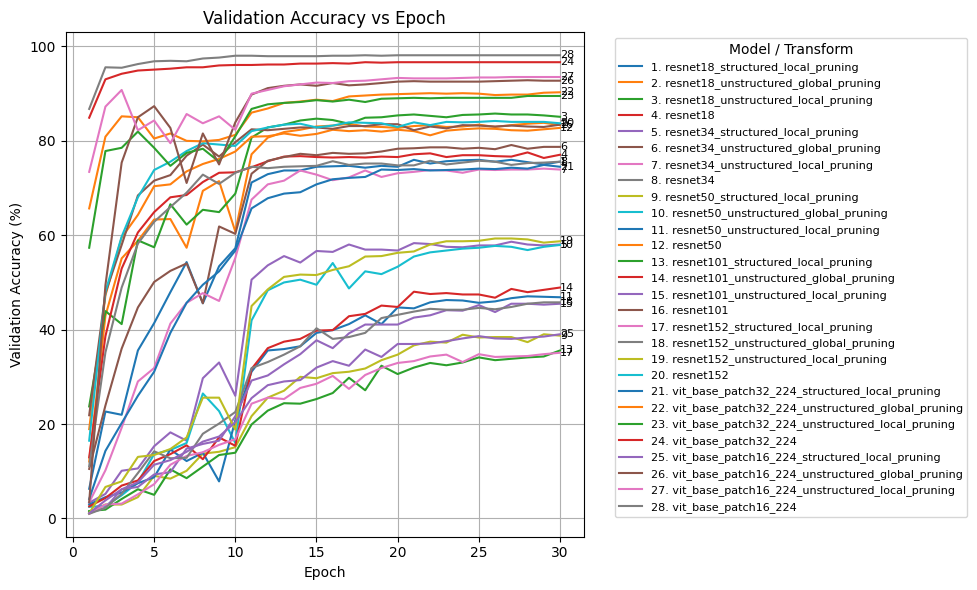

Saved: pruning\test_accuracy_vs_model_size.png


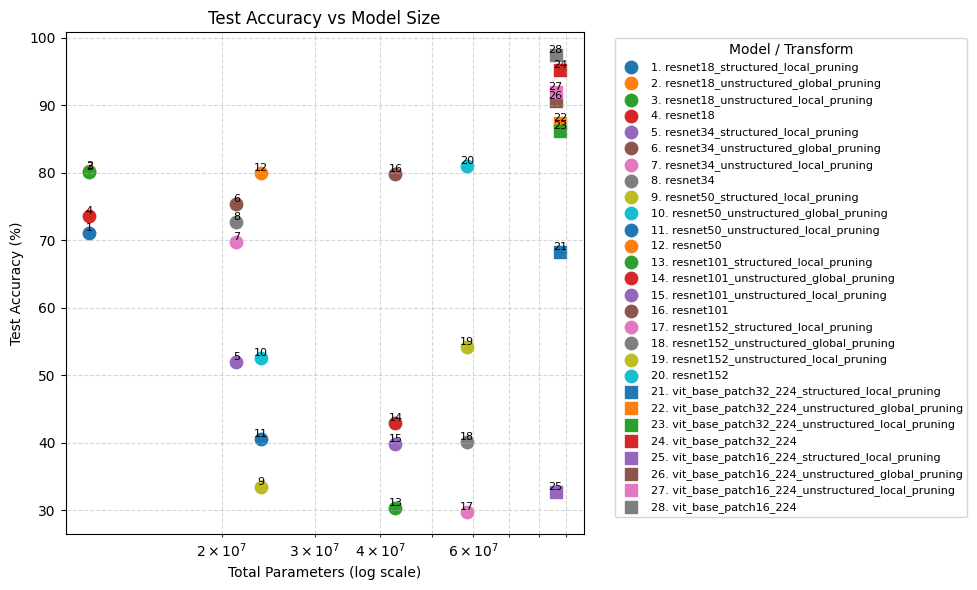

In [81]:
histories = get_or_compute_model_results(
	mode=Mode.FULL_SKIP,
	model_transforms=[
		structured_local_pruning,
		unstructured_global_pruning,
		unstructured_local_pruning
	]
)
plot_model_histories(histories, "pruning")

# Deformable Convolutions

In [87]:
# Prof we can provide our original implementation if you're interested, we decided to switch to open source libraries as it took 15 minutes and to finish training 1 epoch due to open source libraries better integrated with cuda 

class DeformableConv2d(nn.Module):
	def __init__(self, conv: nn.Conv2d, device):
		super().__init__()
		self.in_channels = conv.in_channels
		self.out_channels = conv.out_channels
		self.kernel_size = conv.kernel_size[0]
		self.stride = conv.stride
		self.padding = conv.padding
		self.dilation = conv.dilation
		self.groups = conv.groups
		self.bias = conv.bias is not None

		# Learnable offsets (2*k*k channels)
		self.offset_conv = nn.Conv2d(
			self.in_channels,
			2 * self.kernel_size * self.kernel_size,
			kernel_size=self.kernel_size,
			stride=self.stride,
			padding=self.padding
		)

		# Actual deformable convolution
		self.deform_conv = DeformConv2d(
			self.in_channels,
			self.out_channels,
			kernel_size=self.kernel_size,
			stride=self.stride,
			padding=self.padding,
			dilation=self.dilation,
			groups=self.groups,
			bias=self.bias
		)

		# Copy original weights
		self.deform_conv.weight.data.copy_(conv.weight.data)
		if self.bias:
			self.deform_conv.bias.data.copy_(conv.bias.data)

		self.to(device)

	def forward(self, x):
		offset = self.offset_conv(x)
		return self.deform_conv(x, offset)


class DeformableConvTransform(ModelTransform):
	def __init__(self, name: str = "deformable_convolutions_transform", device: str| torch.device = device):
		if name != "deformable_convolutions_transform":
			print(f"name set to {name}. Note previous saved model weights and model results are saved under deformable_convolutions_transform instead. This will break loading those models.")
		super().__init__(name)
		self.device = device

	def __call__(self, model: nn.Module) -> nn.Module:
		if not isinstance(model, timm.models.resnet.ResNet):
			raise NotImplementedError(f"[{self.name}] Model type {model.__class__} not supported.")

		for module_name, module in model.named_modules():
			if isinstance(module, nn.Conv2d):
				# Skip 1×1 convolutions (likely downsampling or pointwise)
				if module.kernel_size == (1, 1):
					continue

				# Optionally, skip first conv layer if you don't want to deform it
				if module_name == "conv1":
					continue

				# Find parent module
				parent = model
				*path, last = module_name.split(".")
				if not any(x.startswith("layer") for x in path):
					continue
				for p in path:
					parent = getattr(parent, p)

				# Replace with deformable convolution
				setattr(parent, last, DeformableConv2d(module, device=self.device))
				module.requires_grad_(True)


		return model
	
	def applies_to(self, model_name: str) -> bool:
		if "vit" in model_name:
			return False
		elif "resnet" in model_name:
			return True
		else:
			return False

	def applies_to_class(self, model: nn.Module) -> bool:
		if isinstance(model, timm.models.vision_transformer.VisionTransformer):
			return False
		elif isinstance(model, timm.models.resnet.ResNet):
			return True
		else:
			return False

In [88]:
def visualize_all_deformable_offsets(model_name="resnet18", input_image=None, device=device):

	deform_conv = DeformableConvTransform()
	if not deform_conv.applies_to(model_name):
		raise NotImplementedError(f"deformable convolutions are not defined for {model_name}")

	if input_image is None:
		input_image = next(iter(test_loader))[0][0:1]  # shape (1, C, H, W)
	input_image = input_image.to(device)

	# --- load model ---
	model = timm.create_model(model_name, pretrained=False, num_classes=102)
	model = deform_conv(model)
	model.to(device)
	model.eval()

	# --- load weights if exist ---
	transformed_model_name = f"{model_name}_deformable_convolutions_transform"
	weights_path = os.path.join("results", "model_weights", transformed_model_name, f"{transformed_model_name}_best.pth")
	if os.path.exists(weights_path):
		state_dict = torch.load(weights_path, map_location=device)
		model.load_state_dict(state_dict, strict=False)

	# --- get deformable layers ---
	deform_layers = [(name, m) for name, m in model.named_modules() if isinstance(m, DeformableConv2d)]
	if not deform_layers:
		raise RuntimeError("No DeformableConv2d layers found!")

	print(f"Found {len(deform_layers)} deformable layers")

	# --- set up hooks to capture inputs ---
	features = {}

	def get_hook(name):
		def hook(module, input, output):
			features[name] = input[0].detach()
		return hook

	hooks = [m.register_forward_hook(get_hook(name)) for name, m in deform_layers]

	# --- forward pass once to capture features ---
	with torch.no_grad():
		_ = model(input_image)
	# --- visualize each offset map ---
	n_layers = len(deform_layers)
	n_cols = 5
	n_rows = (n_layers + n_cols - 1) // n_cols

	plt.figure(figsize=(4 * n_cols, 4 * n_rows))

	for i, (layer_name, deform_layer) in enumerate(deform_layers, 1):
		if layer_name not in features:
			print(f"Layer {layer_name} not in features, skipping.")
			continue
			
		deform_layer.eval()
		with torch.no_grad():
			# Use the actual feature map captured by the hook
			feature_input = features[layer_name]
			
			if hasattr(deform_layer, 'offset_conv'):
				offset = deform_layer.offset_conv(feature_input)
			else:
				print(f"Layer {layer_name} missing offset_conv, skipping.")
				continue

		offset_np = offset.cpu().numpy()[0]
		H, W = offset_np.shape[1:]
		
		# Average across all offset pairs (x and y)
		offset_x = offset_np[::2].mean(axis=0)
		offset_y = offset_np[1::2].mean(axis=0)
		
		# Create sampling grid - adaptive based on size
		# Use more samples for smaller feature maps
		max_arrows = 20
		step = max(1, max(H, W) // max_arrows)
		
		y_coords = np.arange(0, H, step)
		x_coords = np.arange(0, W, step)
		X, Y = np.meshgrid(x_coords, y_coords)
		
		# Sample offsets at grid points using proper indexing
		offset_x_sampled = offset_x[y_coords[:, None], x_coords]
		offset_y_sampled = offset_y[y_coords[:, None], x_coords]

		plt.subplot(n_rows, n_cols, i)
		
		# Show the feature map as background
		feature_vis = feature_input[0].mean(0).cpu().numpy()
		plt.imshow(feature_vis, cmap='gray', alpha=0.5, extent=[0, W, H, 0])
		
		# Compute magnitude for color scaling
		magnitude = np.sqrt(offset_x_sampled**2 + offset_y_sampled**2)
		
		# Adaptive scaling based on feature map size and offset statistics
		offset_scale = np.percentile(magnitude, 95) if magnitude.max() > 0 else 1.0
		scale_factor = max(H, W) / (20 * max(offset_scale, 0.1))
		
		# Plot arrows with proper coordinates
		plt.quiver(X, Y, offset_x_sampled, offset_y_sampled, 
				magnitude, 
				angles='xy', 
				scale_units='xy', 
				scale=scale_factor,
				cmap='hot',
				alpha=0.8,
				width=0.003,
				headwidth=3,
				headlength=4)
		
		plt.xlim(0, W)
		plt.ylim(H, 0)  # Inverted y-axis to match image coordinates
		plt.title(f"{layer_name}\n{H}x{W}, scale={scale_factor:.2f}", fontsize=8)
		plt.axis('off')

	plt.tight_layout()
	plt.show()

	# cleanup hooks
	for h in hooks:
		h.remove()

In [89]:
# visualize_all_deformable_offsets("resnet18")

Computing performance for 'resnet18_deformable_convolutions_transform'...
Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []


Training Epochs (resnet18):   0%|          | 0/30 [00:00<?, ?epoch/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/30] LR: 0.001000 | Train Loss: 4.0889, Train Acc: 14.31% | Val Loss: 3.6117, Val Acc: 19.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/30] LR: 0.001000 | Train Loss: 2.2736, Train Acc: 42.16% | Val Loss: 2.5860, Val Acc: 34.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/30] LR: 0.001000 | Train Loss: 1.6410, Train Acc: 54.71% | Val Loss: 2.7791, Val Acc: 34.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/30] LR: 0.001000 | Train Loss: 1.2616, Train Acc: 65.29% | Val Loss: 2.3574, Val Acc: 43.43%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/30] LR: 0.001000 | Train Loss: 0.8490, Train Acc: 75.39% | Val Loss: 1.9814, Val Acc: 49.90%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/30] LR: 0.001000 | Train Loss: 0.6713, Train Acc: 80.88% | Val Loss: 1.6293, Val Acc: 58.04%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/30] LR: 0.001000 | Train Loss: 0.6399, Train Acc: 81.96% | Val Loss: 1.5008, Val Acc: 61.08%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/30] LR: 0.001000 | Train Loss: 0.4318, Train Acc: 87.75% | Val Loss: 1.3949, Val Acc: 65.49%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/30] LR: 0.001000 | Train Loss: 0.4055, Train Acc: 88.82% | Val Loss: 1.4939, Val Acc: 62.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/30] LR: 0.001000 | Train Loss: 0.3561, Train Acc: 89.22% | Val Loss: 1.7693, Val Acc: 60.00%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/30] LR: 0.000100 | Train Loss: 0.1847, Train Acc: 94.61% | Val Loss: 1.1034, Val Acc: 70.98%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/30] LR: 0.000100 | Train Loss: 0.0916, Train Acc: 98.14% | Val Loss: 1.0096, Val Acc: 73.14%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/30] LR: 0.000100 | Train Loss: 0.0670, Train Acc: 98.82% | Val Loss: 0.9673, Val Acc: 74.22%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/30] LR: 0.000100 | Train Loss: 0.0493, Train Acc: 99.51% | Val Loss: 0.9261, Val Acc: 75.29%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/30] LR: 0.000100 | Train Loss: 0.0410, Train Acc: 99.61% | Val Loss: 0.9157, Val Acc: 75.20%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/30] LR: 0.000100 | Train Loss: 0.0311, Train Acc: 99.80% | Val Loss: 0.9009, Val Acc: 75.78%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/30] LR: 0.000100 | Train Loss: 0.0383, Train Acc: 99.22% | Val Loss: 0.8904, Val Acc: 76.27%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/30] LR: 0.000100 | Train Loss: 0.0292, Train Acc: 99.61% | Val Loss: 0.8620, Val Acc: 77.45%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/30] LR: 0.000100 | Train Loss: 0.0325, Train Acc: 99.41% | Val Loss: 0.8629, Val Acc: 77.45%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/30] LR: 0.000100 | Train Loss: 0.0274, Train Acc: 99.51% | Val Loss: 0.8656, Val Acc: 77.06%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/30] LR: 0.000010 | Train Loss: 0.0228, Train Acc: 99.90% | Val Loss: 0.8574, Val Acc: 77.45%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/30] LR: 0.000010 | Train Loss: 0.0208, Train Acc: 99.90% | Val Loss: 0.8593, Val Acc: 77.45%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/30] LR: 0.000010 | Train Loss: 0.0295, Train Acc: 99.51% | Val Loss: 0.8616, Val Acc: 77.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/30] LR: 0.000010 | Train Loss: 0.0240, Train Acc: 99.90% | Val Loss: 0.8631, Val Acc: 77.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/30] LR: 0.000010 | Train Loss: 0.0229, Train Acc: 99.90% | Val Loss: 0.8535, Val Acc: 77.06%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/30] LR: 0.000010 | Train Loss: 0.0303, Train Acc: 99.51% | Val Loss: 0.8720, Val Acc: 77.75%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/30] LR: 0.000010 | Train Loss: 0.0241, Train Acc: 99.80% | Val Loss: 0.8554, Val Acc: 77.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/30] LR: 0.000010 | Train Loss: 0.0213, Train Acc: 100.00% | Val Loss: 0.8557, Val Acc: 77.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/30] LR: 0.000010 | Train Loss: 0.0230, Train Acc: 99.80% | Val Loss: 0.8477, Val Acc: 77.16%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/30] LR: 0.000010 | Train Loss: 0.0256, Train Acc: 99.51% | Val Loss: 0.8622, Val Acc: 77.16%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


Best Validation Accuracy: 77.75%

Test Accuracy: 72.74%
Model weights saved to results\model_weights\resnet18_deformable_convolutions_transform\resnet18_deformable_convolutions_transform_best.pth
Metrics saved to results/metrics_resnet18_deformable_convolutions_transform.json
Found existing results for 'resnet18', loading metrics...
Computing performance for 'resnet34_deformable_convolutions_transform'...
Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []


Training Epochs (resnet34):   0%|          | 0/30 [00:00<?, ?epoch/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/30] LR: 0.001000 | Train Loss: 4.6766, Train Acc: 4.80% | Val Loss: 4.7360, Val Acc: 5.20%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/30] LR: 0.001000 | Train Loss: 3.9363, Train Acc: 9.41% | Val Loss: 4.2499, Val Acc: 8.33%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/30] LR: 0.001000 | Train Loss: 3.3615, Train Acc: 16.47% | Val Loss: 3.3139, Val Acc: 18.63%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/30] LR: 0.001000 | Train Loss: 2.9678, Train Acc: 21.86% | Val Loss: 3.7021, Val Acc: 13.73%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/30] LR: 0.001000 | Train Loss: 2.6680, Train Acc: 29.02% | Val Loss: 3.4685, Val Acc: 17.16%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/30] LR: 0.001000 | Train Loss: 2.3756, Train Acc: 34.80% | Val Loss: 2.8677, Val Acc: 27.84%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/30] LR: 0.001000 | Train Loss: 2.1295, Train Acc: 41.47% | Val Loss: 2.5544, Val Acc: 33.43%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/30] LR: 0.001000 | Train Loss: 1.9060, Train Acc: 47.55% | Val Loss: 2.7372, Val Acc: 31.86%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/30] LR: 0.001000 | Train Loss: 1.7715, Train Acc: 50.10% | Val Loss: 3.4609, Val Acc: 25.00%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/30] LR: 0.001000 | Train Loss: 2.0213, Train Acc: 45.10% | Val Loss: 3.4695, Val Acc: 23.04%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/30] LR: 0.000100 | Train Loss: 1.6138, Train Acc: 56.18% | Val Loss: 1.9976, Val Acc: 47.16%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/30] LR: 0.000100 | Train Loss: 1.2538, Train Acc: 66.67% | Val Loss: 1.7692, Val Acc: 52.94%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/30] LR: 0.000100 | Train Loss: 1.0632, Train Acc: 70.39% | Val Loss: 1.6980, Val Acc: 54.51%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/30] LR: 0.000100 | Train Loss: 0.9458, Train Acc: 75.10% | Val Loss: 1.6939, Val Acc: 55.10%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/30] LR: 0.000100 | Train Loss: 0.8572, Train Acc: 76.67% | Val Loss: 1.6154, Val Acc: 56.47%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/30] LR: 0.000100 | Train Loss: 0.7990, Train Acc: 80.10% | Val Loss: 1.6043, Val Acc: 57.16%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/30] LR: 0.000100 | Train Loss: 0.7412, Train Acc: 81.37% | Val Loss: 1.5705, Val Acc: 59.51%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/30] LR: 0.000100 | Train Loss: 0.6588, Train Acc: 82.84% | Val Loss: 1.5263, Val Acc: 59.80%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/30] LR: 0.000100 | Train Loss: 0.6263, Train Acc: 85.59% | Val Loss: 1.5327, Val Acc: 59.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/30] LR: 0.000100 | Train Loss: 0.5902, Train Acc: 85.10% | Val Loss: 1.5004, Val Acc: 60.39%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/30] LR: 0.000010 | Train Loss: 0.5205, Train Acc: 87.45% | Val Loss: 1.5154, Val Acc: 59.80%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/30] LR: 0.000010 | Train Loss: 0.5508, Train Acc: 87.35% | Val Loss: 1.5036, Val Acc: 59.90%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/30] LR: 0.000010 | Train Loss: 0.5242, Train Acc: 86.96% | Val Loss: 1.5223, Val Acc: 59.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/30] LR: 0.000010 | Train Loss: 0.5147, Train Acc: 87.84% | Val Loss: 1.5054, Val Acc: 59.51%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/30] LR: 0.000010 | Train Loss: 0.4737, Train Acc: 89.71% | Val Loss: 1.4854, Val Acc: 60.29%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/30] LR: 0.000010 | Train Loss: 0.5024, Train Acc: 88.43% | Val Loss: 1.4801, Val Acc: 60.78%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/30] LR: 0.000010 | Train Loss: 0.4958, Train Acc: 89.31% | Val Loss: 1.4928, Val Acc: 60.98%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/30] LR: 0.000010 | Train Loss: 0.5013, Train Acc: 88.43% | Val Loss: 1.4912, Val Acc: 60.39%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/30] LR: 0.000010 | Train Loss: 0.4804, Train Acc: 89.22% | Val Loss: 1.5016, Val Acc: 60.29%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/30] LR: 0.000010 | Train Loss: 0.5107, Train Acc: 87.75% | Val Loss: 1.4621, Val Acc: 61.18%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


Best Validation Accuracy: 61.18%

Test Accuracy: 56.20%
Model weights saved to results\model_weights\resnet34_deformable_convolutions_transform\resnet34_deformable_convolutions_transform_best.pth
Metrics saved to results/metrics_resnet34_deformable_convolutions_transform.json
Found existing results for 'resnet34', loading metrics...
Computing performance for 'resnet50_deformable_convolutions_transform'...
Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []


Training Epochs (resnet50):   0%|          | 0/30 [00:00<?, ?epoch/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/30] LR: 0.001000 | Train Loss: 4.5010, Train Acc: 8.92% | Val Loss: 3.1435, Val Acc: 25.00%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/30] LR: 0.001000 | Train Loss: 2.4374, Train Acc: 40.10% | Val Loss: 2.0089, Val Acc: 48.33%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/30] LR: 0.001000 | Train Loss: 1.4374, Train Acc: 60.20% | Val Loss: 1.8150, Val Acc: 52.75%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/30] LR: 0.001000 | Train Loss: 0.8983, Train Acc: 75.98% | Val Loss: 0.9736, Val Acc: 73.63%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/30] LR: 0.001000 | Train Loss: 0.5286, Train Acc: 85.29% | Val Loss: 1.1236, Val Acc: 68.24%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/30] LR: 0.001000 | Train Loss: 0.3762, Train Acc: 90.29% | Val Loss: 1.1325, Val Acc: 72.75%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/30] LR: 0.001000 | Train Loss: 0.3166, Train Acc: 91.76% | Val Loss: 1.0050, Val Acc: 73.82%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/30] LR: 0.001000 | Train Loss: 0.2306, Train Acc: 93.33% | Val Loss: 0.9331, Val Acc: 77.94%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/30] LR: 0.001000 | Train Loss: 0.1904, Train Acc: 95.00% | Val Loss: 0.8936, Val Acc: 78.04%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/30] LR: 0.001000 | Train Loss: 0.2331, Train Acc: 93.73% | Val Loss: 1.1998, Val Acc: 71.67%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/30] LR: 0.000100 | Train Loss: 0.1492, Train Acc: 96.37% | Val Loss: 0.6844, Val Acc: 82.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/30] LR: 0.000100 | Train Loss: 0.0583, Train Acc: 98.82% | Val Loss: 0.6171, Val Acc: 84.31%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/30] LR: 0.000100 | Train Loss: 0.0539, Train Acc: 98.73% | Val Loss: 0.5791, Val Acc: 85.29%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/30] LR: 0.000100 | Train Loss: 0.0417, Train Acc: 99.41% | Val Loss: 0.5729, Val Acc: 85.78%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/30] LR: 0.000100 | Train Loss: 0.0448, Train Acc: 99.02% | Val Loss: 0.5510, Val Acc: 86.08%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/30] LR: 0.000100 | Train Loss: 0.0308, Train Acc: 99.61% | Val Loss: 0.5388, Val Acc: 86.47%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/30] LR: 0.000100 | Train Loss: 0.0225, Train Acc: 99.61% | Val Loss: 0.5380, Val Acc: 86.27%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/30] LR: 0.000100 | Train Loss: 0.0269, Train Acc: 99.80% | Val Loss: 0.5394, Val Acc: 86.18%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/30] LR: 0.000100 | Train Loss: 0.0168, Train Acc: 100.00% | Val Loss: 0.5327, Val Acc: 86.18%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/30] LR: 0.000100 | Train Loss: 0.0151, Train Acc: 100.00% | Val Loss: 0.5292, Val Acc: 86.37%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/30] LR: 0.000010 | Train Loss: 0.0164, Train Acc: 100.00% | Val Loss: 0.5382, Val Acc: 85.98%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/30] LR: 0.000010 | Train Loss: 0.0201, Train Acc: 99.61% | Val Loss: 0.5368, Val Acc: 85.59%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/30] LR: 0.000010 | Train Loss: 0.0173, Train Acc: 99.80% | Val Loss: 0.5429, Val Acc: 85.39%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/30] LR: 0.000010 | Train Loss: 0.0146, Train Acc: 100.00% | Val Loss: 0.5438, Val Acc: 86.08%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/30] LR: 0.000010 | Train Loss: 0.0172, Train Acc: 99.80% | Val Loss: 0.5365, Val Acc: 86.27%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/30] LR: 0.000010 | Train Loss: 0.0158, Train Acc: 99.90% | Val Loss: 0.5278, Val Acc: 86.08%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/30] LR: 0.000010 | Train Loss: 0.0225, Train Acc: 99.80% | Val Loss: 0.5380, Val Acc: 85.98%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/30] LR: 0.000010 | Train Loss: 0.0161, Train Acc: 100.00% | Val Loss: 0.5278, Val Acc: 86.18%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/30] LR: 0.000010 | Train Loss: 0.0187, Train Acc: 99.80% | Val Loss: 0.5258, Val Acc: 86.27%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/30] LR: 0.000010 | Train Loss: 0.0150, Train Acc: 99.80% | Val Loss: 0.5291, Val Acc: 86.47%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


Best Validation Accuracy: 86.47%

Test Accuracy: 82.70%
Model weights saved to results\model_weights\resnet50_deformable_convolutions_transform\resnet50_deformable_convolutions_transform_best.pth
Metrics saved to results/metrics_resnet50_deformable_convolutions_transform.json
Found existing results for 'resnet50', loading metrics...
Computing performance for 'resnet101_deformable_convolutions_transform'...
Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []


Training Epochs (resnet101):   0%|          | 0/30 [00:00<?, ?epoch/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/30] LR: 0.001000 | Train Loss: 4.7682, Train Acc: 3.82% | Val Loss: 4.6278, Val Acc: 2.55%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/30] LR: 0.001000 | Train Loss: 3.5521, Train Acc: 17.06% | Val Loss: 2.7597, Val Acc: 32.16%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/30] LR: 0.001000 | Train Loss: 2.1334, Train Acc: 43.92% | Val Loss: 1.9691, Val Acc: 47.55%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/30] LR: 0.001000 | Train Loss: 1.2549, Train Acc: 66.57% | Val Loss: 1.7422, Val Acc: 54.71%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/30] LR: 0.001000 | Train Loss: 0.8021, Train Acc: 77.75% | Val Loss: 1.3972, Val Acc: 62.65%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/30] LR: 0.001000 | Train Loss: 0.6688, Train Acc: 81.57% | Val Loss: 1.3161, Val Acc: 67.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/30] LR: 0.001000 | Train Loss: 0.3800, Train Acc: 89.80% | Val Loss: 0.8848, Val Acc: 76.08%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/30] LR: 0.001000 | Train Loss: 0.2535, Train Acc: 93.14% | Val Loss: 1.1528, Val Acc: 70.88%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/30] LR: 0.001000 | Train Loss: 0.2058, Train Acc: 93.92% | Val Loss: 1.1168, Val Acc: 71.47%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/30] LR: 0.001000 | Train Loss: 0.1999, Train Acc: 94.22% | Val Loss: 1.0936, Val Acc: 71.18%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/30] LR: 0.000100 | Train Loss: 0.1304, Train Acc: 96.37% | Val Loss: 0.7897, Val Acc: 77.94%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/30] LR: 0.000100 | Train Loss: 0.0845, Train Acc: 98.33% | Val Loss: 0.7154, Val Acc: 80.78%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/30] LR: 0.000100 | Train Loss: 0.0519, Train Acc: 98.53% | Val Loss: 0.6551, Val Acc: 82.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/30] LR: 0.000100 | Train Loss: 0.0359, Train Acc: 99.41% | Val Loss: 0.6502, Val Acc: 83.24%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/30] LR: 0.000100 | Train Loss: 0.0312, Train Acc: 99.71% | Val Loss: 0.6398, Val Acc: 83.73%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/30] LR: 0.000100 | Train Loss: 0.0357, Train Acc: 99.61% | Val Loss: 0.6288, Val Acc: 83.92%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/30] LR: 0.000100 | Train Loss: 0.0288, Train Acc: 99.80% | Val Loss: 0.6229, Val Acc: 83.73%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/30] LR: 0.000100 | Train Loss: 0.0287, Train Acc: 99.61% | Val Loss: 0.6200, Val Acc: 83.24%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/30] LR: 0.000100 | Train Loss: 0.0229, Train Acc: 99.90% | Val Loss: 0.5928, Val Acc: 84.12%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/30] LR: 0.000100 | Train Loss: 0.0170, Train Acc: 100.00% | Val Loss: 0.5997, Val Acc: 84.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/30] LR: 0.000010 | Train Loss: 0.0189, Train Acc: 99.61% | Val Loss: 0.5979, Val Acc: 83.92%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/30] LR: 0.000010 | Train Loss: 0.0216, Train Acc: 99.90% | Val Loss: 0.5758, Val Acc: 84.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/30] LR: 0.000010 | Train Loss: 0.0163, Train Acc: 100.00% | Val Loss: 0.5861, Val Acc: 84.31%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/30] LR: 0.000010 | Train Loss: 0.0205, Train Acc: 99.90% | Val Loss: 0.5757, Val Acc: 84.90%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/30] LR: 0.000010 | Train Loss: 0.0179, Train Acc: 99.80% | Val Loss: 0.5850, Val Acc: 84.31%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/30] LR: 0.000010 | Train Loss: 0.0230, Train Acc: 99.61% | Val Loss: 0.5948, Val Acc: 84.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/30] LR: 0.000010 | Train Loss: 0.0152, Train Acc: 99.90% | Val Loss: 0.5887, Val Acc: 84.12%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/30] LR: 0.000010 | Train Loss: 0.0194, Train Acc: 99.80% | Val Loss: 0.5912, Val Acc: 84.12%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/30] LR: 0.000010 | Train Loss: 0.0202, Train Acc: 99.71% | Val Loss: 0.5938, Val Acc: 84.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/30] LR: 0.000010 | Train Loss: 0.0159, Train Acc: 100.00% | Val Loss: 0.5846, Val Acc: 83.92%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


Best Validation Accuracy: 84.90%

Test Accuracy: 81.12%
Model weights saved to results\model_weights\resnet101_deformable_convolutions_transform\resnet101_deformable_convolutions_transform_best.pth
Metrics saved to results/metrics_resnet101_deformable_convolutions_transform.json
Found existing results for 'resnet101', loading metrics...
Computing performance for 'resnet152_deformable_convolutions_transform'...
Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []


Training Epochs (resnet152):   0%|          | 0/30 [00:00<?, ?epoch/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/30] LR: 0.001000 | Train Loss: 4.8436, Train Acc: 1.57% | Val Loss: 5.7664, Val Acc: 2.45%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/30] LR: 0.001000 | Train Loss: 4.1267, Train Acc: 10.10% | Val Loss: 3.5355, Val Acc: 18.24%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/30] LR: 0.001000 | Train Loss: 2.9136, Train Acc: 28.82% | Val Loss: 3.0212, Val Acc: 31.57%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/30] LR: 0.001000 | Train Loss: 1.9770, Train Acc: 46.08% | Val Loss: 2.1188, Val Acc: 45.39%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/30] LR: 0.001000 | Train Loss: 1.3953, Train Acc: 58.92% | Val Loss: 1.8985, Val Acc: 49.51%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/30] LR: 0.001000 | Train Loss: 0.9592, Train Acc: 73.43% | Val Loss: 1.8680, Val Acc: 54.22%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/30] LR: 0.001000 | Train Loss: 0.6564, Train Acc: 79.90% | Val Loss: 1.4540, Val Acc: 62.65%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/30] LR: 0.001000 | Train Loss: 0.4513, Train Acc: 88.04% | Val Loss: 1.4611, Val Acc: 64.71%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/30] LR: 0.001000 | Train Loss: 0.3791, Train Acc: 89.12% | Val Loss: 1.1846, Val Acc: 69.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/30] LR: 0.001000 | Train Loss: 0.2176, Train Acc: 94.51% | Val Loss: 1.1520, Val Acc: 71.57%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/30] LR: 0.000100 | Train Loss: 0.1552, Train Acc: 96.27% | Val Loss: 0.8822, Val Acc: 77.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/30] LR: 0.000100 | Train Loss: 0.0845, Train Acc: 98.43% | Val Loss: 0.8190, Val Acc: 78.82%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026F9844B7E0>
Traceback (most recent call last):
  File "c:\Users\kyeyo\OneDrive\Desktop\SC4001\Group Assignment\mmcv_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\kyeyo\OneDrive\Desktop\SC4001\Group Assignment\mmcv_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/30] LR: 0.000100 | Train Loss: 0.0627, Train Acc: 99.02% | Val Loss: 0.8198, Val Acc: 79.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/30] LR: 0.000100 | Train Loss: 0.0459, Train Acc: 99.31% | Val Loss: 0.7982, Val Acc: 79.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/30] LR: 0.000100 | Train Loss: 0.0479, Train Acc: 99.31% | Val Loss: 0.7792, Val Acc: 79.12%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/30] LR: 0.000100 | Train Loss: 0.0404, Train Acc: 99.71% | Val Loss: 0.8173, Val Acc: 78.92%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/30] LR: 0.000100 | Train Loss: 0.0403, Train Acc: 99.71% | Val Loss: 0.7820, Val Acc: 79.22%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/30] LR: 0.000100 | Train Loss: 0.0340, Train Acc: 99.71% | Val Loss: 0.7708, Val Acc: 79.51%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/30] LR: 0.000100 | Train Loss: 0.0382, Train Acc: 99.31% | Val Loss: 0.7819, Val Acc: 79.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/30] LR: 0.000100 | Train Loss: 0.0314, Train Acc: 99.71% | Val Loss: 0.7688, Val Acc: 79.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/30] LR: 0.000010 | Train Loss: 0.0291, Train Acc: 99.71% | Val Loss: 0.7853, Val Acc: 79.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/30] LR: 0.000010 | Train Loss: 0.0278, Train Acc: 99.80% | Val Loss: 0.7757, Val Acc: 79.90%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/30] LR: 0.000010 | Train Loss: 0.0299, Train Acc: 99.71% | Val Loss: 0.7915, Val Acc: 79.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/30] LR: 0.000010 | Train Loss: 0.0253, Train Acc: 99.61% | Val Loss: 0.7773, Val Acc: 79.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/30] LR: 0.000010 | Train Loss: 0.0289, Train Acc: 99.71% | Val Loss: 0.7766, Val Acc: 79.80%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/30] LR: 0.000010 | Train Loss: 0.0250, Train Acc: 100.00% | Val Loss: 0.7802, Val Acc: 79.41%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/30] LR: 0.000010 | Train Loss: 0.0245, Train Acc: 99.80% | Val Loss: 0.7670, Val Acc: 80.29%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/30] LR: 0.000010 | Train Loss: 0.0285, Train Acc: 99.80% | Val Loss: 0.7719, Val Acc: 79.71%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/30] LR: 0.000010 | Train Loss: 0.0261, Train Acc: 99.80% | Val Loss: 0.7894, Val Acc: 79.71%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/30] LR: 0.000010 | Train Loss: 0.0219, Train Acc: 99.71% | Val Loss: 0.7741, Val Acc: 79.31%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


Best Validation Accuracy: 80.29%

Test Accuracy: 77.18%
Model weights saved to results\model_weights\resnet152_deformable_convolutions_transform\resnet152_deformable_convolutions_transform_best.pth
Metrics saved to results/metrics_resnet152_deformable_convolutions_transform.json
Found existing results for 'resnet152', loading metrics...
Found existing results for 'vit_base_patch32_224', loading metrics...
Found existing results for 'vit_base_patch16_224', loading metrics...
All histories saved to results/all_histories.json
Saved: deformable_conv\validation_accuracy_vs_epoch.png


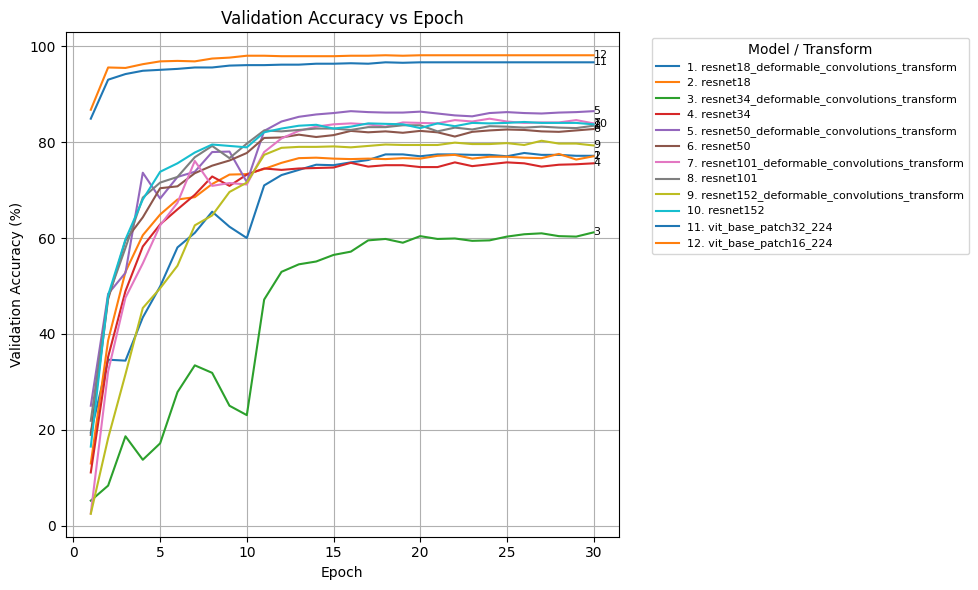

Saved: deformable_conv\test_accuracy_vs_model_size.png


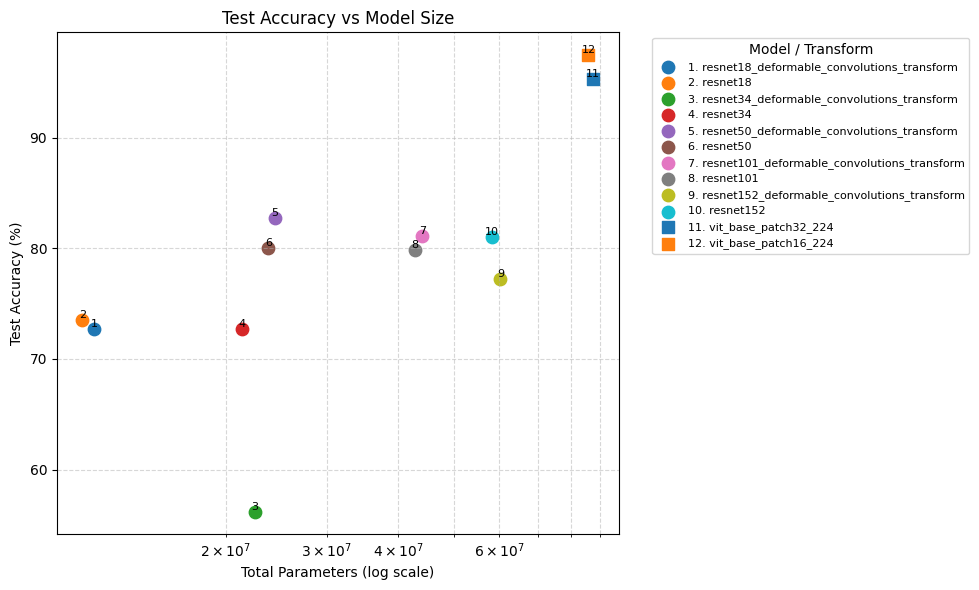

In [90]:
deformable_transform = DeformableConvTransform()
histories = get_or_compute_model_results(model_transforms=(deformable_transform,) 
                                         , mode=Mode.FULL_SKIP)
plot_model_histories(histories, "deformable_conv") 

# Overall diagram

Found existing results for 'resnet18_structured_local_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet18_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet18_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet18', loading metrics...
Found existing results for 'resnet34_structured_local_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_global_pruning', loading metrics...
Found existing results for 'resnet34_unstructured_local_pruning', loading metrics...
Found existing results for 'resnet34_deformable_convolutions_transform', loading metrics...
Found existing results for 'resnet34', loading metrics...
Found existing results for 'resnet50_structured_local_pruning', loading metrics...
Found existing results for 'resnet50_unstructured_global_pruning', loading metrics...
Found existing results 

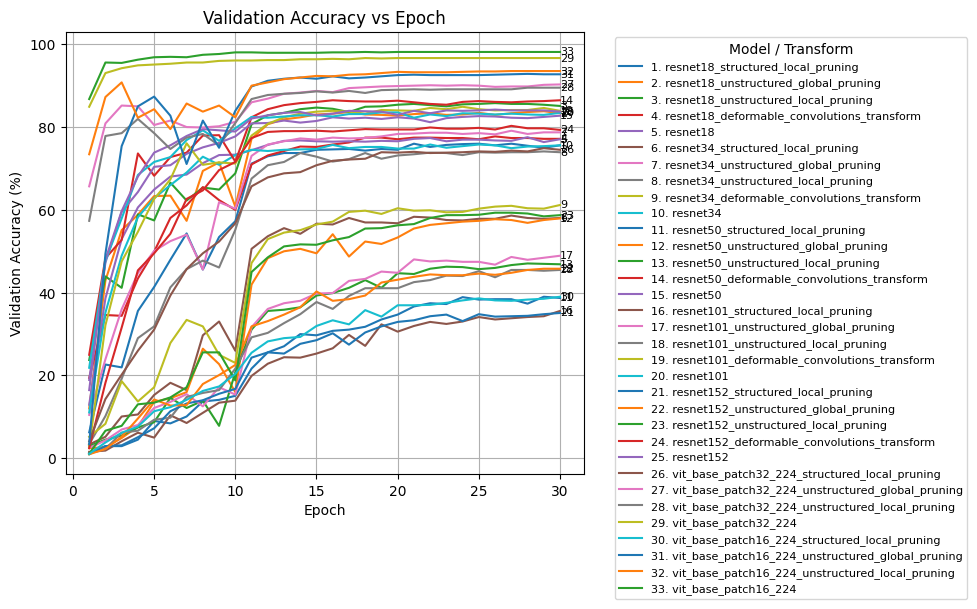

Saved: overall\test_accuracy_vs_model_size.png


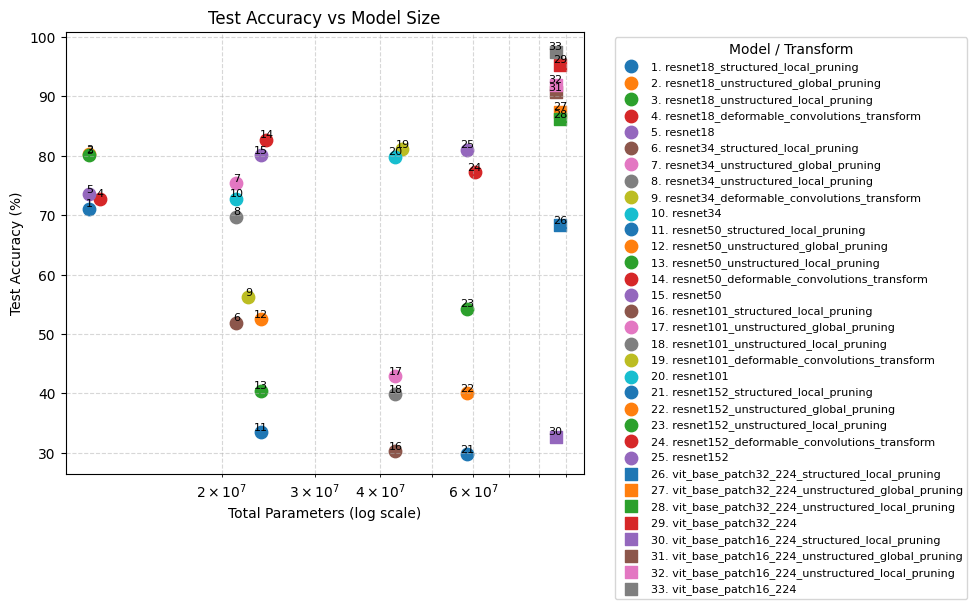

In [91]:
histories = get_or_compute_model_results(model_transforms=(structured_local_pruning, unstructured_global_pruning, unstructured_local_pruning, deformable_transform,)
                                         , mode=Mode.FULL_SKIP)
plot_model_histories(histories, "overall")

# visual prompt tuning